### Configuration

In [ ]:
!nvidia-smi

Sun Feb  5 17:20:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install required packages

!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 24.2 MB/s eta 0:00:00


In [ ]:
!unzip /content/dataset.zip -d /content/dataset/

Archive:  /content/dataset.zip
  inflating: /content/dataset/saadi.txt  
  inflating: /content/dataset/parvin.txt  
  inflating: /content/dataset/bahar.txt  
  inflating: /content/dataset/saeb.txt  
  inflating: /content/dataset/jami.txt  
  inflating: /content/dataset/hafez.txt  
  inflating: /content/dataset/attar.txt  
  inflating: /content/dataset/rahi.txt  
  inflating: /content/dataset/moulavi.txt  
  inflating: /content/dataset/roodaki.txt  


### Libraries


In [ ]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

### Prosessing Dataset

In [ ]:
os.chdir('/content/dataset/')

In [ ]:
data = ({'poem':[],'label':[]})
df = pd.DataFrame(data)

In [ ]:
max_poem = 5000
file_name = ['attar','bahar','hafez','jami','moulavi','parvin','rahi','roodaki','saadi','saeb']
for j in range(len(file_name)):
  i=0
  print("processing for ",file_name[j])
  with open(file_name[j]+'.txt') as f:
      for line in f.readlines():
        i+=1
        if(i>max_poem):
          break
        if(i>=3):
          #print(line)
          new_row = {'poem':line.split('\n')[0] , 'label':file_name[j]}
          df = df.append(new_row, ignore_index=True)
df = df.sample(frac = 1)


processing for  attar
processing for  bahar
processing for  hafez
processing for  jami
processing for  moulavi
processing for  parvin
processing for  rahi
processing for  roodaki
processing for  saadi
processing for  saeb


In [ ]:
df.head()

,poem,label
9451,زان گشت مرقدش ز جهان سینه تراب,saeb
256,بوده ام بی تو به صد سوز امروز,attar
1255,نراندی بر آن هرکسی مرحبا,bahar
9309,حور و غلمان می ربایند از برای گوشوار,saeb
4852,اندرین وادی مرو بی این دلیل,moulavi


In [ ]:
labels = list(sorted(df['label'].unique()))

In [ ]:
new_data = df
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['poem'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['poem'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['poem'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(38322, 3)
(4259, 3)
(4732, 3)


In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'attar': 0, 'bahar': 1, 'hafez': 2, 'jami': 3, 'moulavi': 4, 'parvin': 5, 'rahi': 6, 'roodaki': 7, 'saadi': 8, 'saeb': 9}
id2label: {0: 'attar', 1: 'bahar', 2: 'hafez', 3: 'jami', 4: 'moulavi', 5: 'parvin', 6: 'rahi', 7: 'roodaki', 8: 'saadi', 9: 'saeb'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "attar",
    "1": "bahar",
    "2": "hafez",
    "3": "jami",
    "4": "moulavi",
    "5": "parvin",
    "6": "rahi",
    "7": "roodaki",
    "8": "saadi",
    "9": "saeb"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "attar": 0,
    "bahar": 1,
    "hafez": 2,
    "jami": 3,
    "moulavi": 4,
    "parvin": 5,
    "rahi": 6,
    "roodaki": 7,
    "saadi": 8,
    "saeb": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

  0%|          | 0/38322 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/38322 [00:00<?, ?it/s]

  0%|          | 0/4259 [00:00<?, ?it/s]

  0%|          | 0/4259 [00:00<?, ?it/s]

  0%|          | 0/4732 [00:00<?, ?it/s]

  0%|          | 0/4732 [00:00<?, ?it/s]

  0%|          | 0/4732 [00:00<?, ?it/s]

  0%|          | 0/4732 [00:00<?, ?it/s]

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(2395, 266)

### Fine-Tune with Adam Optimizer

In [48]:
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
hist = model.fit(train_dataset,validation_data=valid_dataset,steps_per_epoch=train_steps,validation_steps=valid_steps,epochs=EPOCHS,verbose=1)
pre = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print('Evaluate')
print("\n",pre,"\n")


predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print("\n",classification_report(ytest, ypred, target_names=labels),"\n")


print(f'F1: {f1_score(ytest, ypred, average="micro")}')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2395/2395 [==============================] - 1073s 442ms/step - loss: 1.5159 - accuracy: 0.4795 - val_loss: 1.1940 - val_accuracy: 0.5916
Epoch 2/3
2395/2395 [==============================] - 1055s 440ms/step - loss: 0.9813 - accuracy: 0.6728 - val_loss: 1.1172 - val_accuracy: 0.6306
Epoch 3/3
296/296 [==============================] - 44s 150ms/step - loss: 1.2021 - accuracy: 0.6418
Evaluate

 [1.20210862159729, 0.6418005228042603] 

148/148 [==============================] - 47s 270ms/step

               precision    recall  f1-score   support

       attar       0.62      0.66      0.64       500
       bahar       0.59      0.59      0.59       500
       hafez       0.57      0.67      0.62       500
        jami       0.72      0.72      0.72       500
     moulavi       0.74      0.63      0.68       500
      parvin       0.62      0.55      0.59       500
        rahi       0.77      0.82      0.79       500
     roodaki       0.35      0.35      0.35       233
   

In [67]:
model.summary()

Model: "tf_bert_for_sequence_classification_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
 dropout_493 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162,849,034
Trainable params: 162,849,034
Non-trainable params: 0
_________________________________________________________________


In [49]:
from sklearn.metrics import f1_score
acc = f1_score(ytest, ypred, average='micro')
print("Avg micro F1 score= ",acc)

Avg micro F1 score=  0.6418005071851226


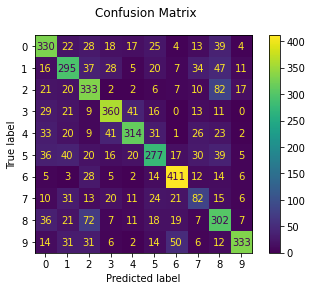

In [50]:
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred).figure_.suptitle("Confusion Matrix")
plt.show()

### Fine-Tune with SGD Optimizer

In [36]:
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
hist = model.fit(train_dataset,validation_data=valid_dataset,steps_per_epoch=train_steps,validation_steps=valid_steps,epochs=EPOCHS,verbose=1)
pre = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print('Evaluate')
print("\n",pre,"\n")


predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print("\n",classification_report(ytest, ypred, target_names=labels),"\n")


print(f'F1: {f1_score(ytest, ypred, average="micro")}')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2395/2395 [==============================] - 969s 398ms/step - loss: 2.3091 - accuracy: 0.1124 - val_loss: 2.2603 - val_accuracy: 0.1812
Epoch 2/3
2395/2395 [==============================] - 950s 397ms/step - loss: 2.2501 - accuracy: 0.1714 - val_loss: 2.2062 - val_accuracy: 0.1955
Epoch 3/3
296/296 [==============================] - 42s 143ms/step - loss: 2.1729 - accuracy: 0.1993
Evaluate

 [2.172940492630005, 0.1992814838886261] 

148/148 [==============================] - 42s 266ms/step

               precision    recall  f1-score   support

       attar       0.11      0.15      0.13       500
       bahar       0.13      0.25      0.17       500
       hafez       0.15      0.24      0.18       500
        jami       0.18      0.24      0.20       500
     moulavi       0.16      0.04      0.06       500
      parvin       0.18      0.05      0.08       500
        rahi       0.77      0.63      0.70       500
     roodaki       0.00      0.00      0.00       233
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
from sklearn.metrics import f1_score
acc = f1_score(ytest, ypred, average='micro')
print("Avg micro F1 score= ",acc)

Avg micro F1 score=  0.1992814877430262


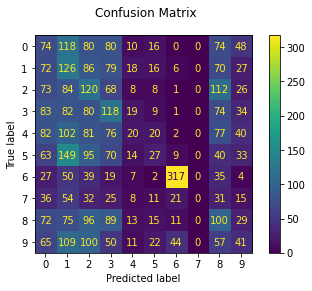

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred).figure_.suptitle("Confusion Matrix")
plt.show()

### Training just last layer (part a)

In [41]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [70]:
base_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
i=1
for layer in base_model.layers:
  if(i==1):
    layer.trainable = False
  i+=1
model.bert.trainable = False
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
base_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
hist = base_model.fit(train_dataset,validation_data=valid_dataset,steps_per_epoch=train_steps,validation_steps=valid_steps,epochs=EPOCHS,verbose=1)
pre = base_model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print('Evaluate')
print("\n",pre,"\n")


predictions =base_model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print("\n",classification_report(ytest, ypred, target_names=labels),"\n")


print(f'F1: {f1_score(ytest, ypred, average="micro")}')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
2395/2395 [==============================] - 429s 174ms/step - loss: 2.1753 - accuracy: 0.1954 - val_loss: 2.0969 - val_accuracy: 0.2493
Epoch 2/3
2395/2395 [==============================] - 414s 173ms/step - loss: 2.1053 - accuracy: 0.2371 - val_loss: 2.0646 - val_accuracy: 0.2845
Epoch 3/3
296/296 [==============================] - 43s 146ms/step - loss: 2.0516 - accuracy: 0.2863
Evaluate

 [2.051553964614868, 0.28634825348854065] 

148/148 [==============================] - 43s 267ms/step

               precision    recall  f1-score   support

       attar       0.21      0.38      0.27       500
       bahar       0.24      0.22      0.23       500
       hafez       0.20      0.40      0.27       500
        jami       0.32      0.34      0.33       500
     moulavi       0.23      0.14      0.17       500
      parvin       0.24      0.17      0.20       500
        rahi       0.77      0.64      0.70       500
     roodaki       0.00      0.00      0.00       233
   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


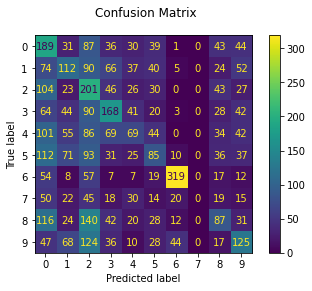

In [71]:
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred).figure_.suptitle("Confusion Matrix")
plt.show()

In [72]:
from sklearn.metrics import f1_score
acc = f1_score(ytest, ypred, average='micro')
print("Avg micro F1 score= ",acc)

Avg micro F1 score=  0.2863482671174979


In [73]:
base_model.summary()

Model: "tf_bert_for_sequence_classification_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
 dropout_531 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162,849,034
Trainable params: 7,690
Non-trainable params: 162,841,344
_________________________________________________________________
